## Création deso utils de manipulation



In [1]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
import glob




Ecriture d'une fonction pour lire les données 

In [2]:
path="/Users/bouchet/Documents/Cours/Cours /AgroParisTech /3A/IODAA/datacamp/lwfa_datacamp2024-2/data/train"


In [3]:
device="cpu"

In [ ]:
!pip install -r requirements.txt
!python download_data.py


In [6]:
def open_diag(simulation,iter) : 
        with open(r"{}/S{:03d}_{:06d}_01.pkl".format(path,simulation,iter), 'rb') as f:
             diag_1 = pickle.load(f)
        return diag_1


In [ ]:
dic=open_diag(0,3600)
print(dic.keys())


In [10]:

def plot_label_box(ax, file_path, xlim, ylim):

    class_colors = ['red', 'C1', 'C2', 'C4']
    with open(file_path, 'rb') as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])
            xcn = float(line.split()[1])
            ycn = float(line.split()[2])
            wn = float(line.split()[3])
            hn = float(line.split()[4])

            xmin = xlim[0] + (xlim[1]-xlim[0]) * (xcn - wn*0.5)
            xmax = xlim[0] + (xlim[1]-xlim[0]) * (xcn + wn*0.5)
            ymin = ylim[0] + (ylim[1]-ylim[0]) * (ycn - hn*0.5)
            ymax = ylim[0] + (ylim[1]-ylim[0]) * (ycn + hn*0.5)

            width = xmax - xmin
            height = ymax - ymin

            ax.add_patch(plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor=class_colors[class_id], linewidth=2))


def plot_diag(simulation,iter) : 


     # colors for the labels
    class_colors = ['red', 'C1', 'C2', 'C4']
    with open(r"{}/S{:03d}_{:06d}_00.pkl".format(path,simulation,iter), 'rb') as f:
             diag_0 = pickle.load(f)
    with open(r"{}/S{:03d}_{:06d}_01.pkl".format(path,simulation,iter), 'rb') as f:
             diag_1 = pickle.load(f)
    with open(r"{}/S{:03d}_{:06d}_02.pkl".format(path,simulation,iter), 'rb') as f:
             diag_2 = pickle.load(f)
     
    fig0 = plt.figure(figsize=(18, 10), dpi=80)
    gs = plt.GridSpec(2, 3)
    ax0 = plt.subplot(gs[:,0])
    ax1 = plt.subplot(gs[:,1])
    ax2 = plt.subplot(gs[:,2])

    # _________________________________________________________
    # First diag: 
    x_axis = np.linspace(diag_0["x_min"], diag_0["x_max"], diag_0["x_size"])
    y_axis = np.linspace(diag_0["y_min"], diag_0["y_max"], diag_0["y_size"])

    
    im0 = ax0.pcolormesh(x_axis,y_axis,diag_0['data'],
                        cmap=plt.get_cmap("plasma"),
                        #norm=norm,
                        shading='auto')

    im0.set_clim(vmin=0, vmax=2)

    ax0.set_xlabel(diag_0["x_label"])
    ax0.set_ylabel(diag_0["y_label"])
    ax0.set_aspect(1)
    ax0.set_title(diag_0["data_label"])
    cb0 = plt.colorbar(im0)

    # Add the object boxes
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    plot_label_box(ax0,"{}/S{:03d}_{:06d}_00.txt".format(path,simulation, iter), xlim, ylim)


    # _________________________________________________________
    # Second diag: charge density of electrons from Nitrogen

    im1 = ax1.pcolormesh(x_axis,y_axis,diag_1['data'],
                        cmap=plt.get_cmap("viridis"),
                        #norm=norm,
                        shading='auto')

    im1.set_clim(vmin=1e-5, vmax=1)

    ax1.set_xlabel(diag_1["x_label"])
    ax1.set_ylabel(diag_1["y_label"])
    ax1.set_aspect(1)

    norm = colors.LogNorm(vmin=1e-5, vmax=1)
    im1.set_norm(norm)
    ax1.set_title(diag_1["data_label"])
    cb1 = plt.colorbar(im1)

    # Add the object boxes
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    plot_label_box(ax1,"{}/S{:03d}_{:06d}_00.txt".format(path,simulation, iter), xlim, ylim)

    # _________________________________________________________
    # Third diag: laser envelope

    im2 = ax2.pcolormesh(x_axis,y_axis,diag_2['data'],
                        cmap=plt.get_cmap("Reds"),
                        #norm=norm,
                        shading='auto')

    im2.set_clim(vmin=0, vmax=1)

    ax2.set_xlabel(diag_2["x_label"])
    ax2.set_ylabel(diag_2["y_label"])
    ax2.set_aspect(1)

    ax2.set_title("Laser envelope intensity")
    cb2 = plt.colorbar(im2)

    plt.tight_layout()

    plt.show()



In [ ]:
plot_diag(0,15600)

### Création d'un dataloader

In [4]:
import torch 
import torchvision.transforms as transforms


In [5]:
import torch.utils

transformer=transforms.Compose(
    [
        transforms.ToTensor()
    
    ]
)

class dataset_LWAS(torch.utils.data.Dataset) : 

    def __init__(self,X,transform,Y=None) :
        self.x=X
        self.y=Y
        self.transform=transform

    def __len__(self) : 
        return len(self.x)
    

    def __getitem__(self,idx): 
        img=self.x[idx]['data']
        img=self.transform(img).to(device).to(torch.float32) ## Ici, je ne sais pasp ourquoi mais mes images s'ouvrent en float16 : obligé de forcer la conversion en float32
        #print("shape : ",img.shape)
        img=img.permute(1,2,0)
        img_width=img.shape[2]
        img_height=img.shape[1]
        if img.dim()==2 : 
            img.unsqueeze_(0)
      
        if self.y is not None:
          
                boxes = []
                labels = []
                for box in self.y[idx]:

                    x_center, y_center, width, height = box['bbox']
                    
               
                    x1 = (x_center - width/2) * img_width
                    y1 = (y_center - height/2) * img_height
                    x2 = (x_center + width/2) * img_width
                    y2 = (y_center + height/2) * img_height
                    
                
                
                    if x1 >= 0 and y1 >= 0 and x2 <= img_width and y2 <= img_height:
                        if x2 > x1 and y2 > y1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(box['class'] + 1)  

                if boxes:
                    target = {
                        'boxes': torch.FloatTensor(boxes).to(device),
                        'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                    }
                else:
                    
                    target = {
                        'boxes': torch.FloatTensor(size=(0, 4)),
                        'labels': torch.tensor([], dtype=torch.int64)
                    }
               
                return img, target
            
        return img
    


###On créee un deuxième objet dataset qui permet de choisir ou non de charger toutes les données en mémoire dans le dataset 
import os 
class dataset_LWAS_2(torch.utils.data.Dataset) : 

    def __init__(self,transform,X,Y=None,preload=True,path=None,train=True) :
        if preload : 
            self.x=X
            self.y=Y
            self.transform=transform
            self.preload=True
            self.train=train
        else : 
            self.x=None
            self.y=None
            self.preload=False 
            self.transform=transform
            self.train=train
            if path is None : 
                raise     Exception("preload est fixé à False, mais aucun chemin n'est spécifié")
            self.path=path
            list_attempts_=os.listdir(path)
            self.list_x_names = list() 
            for i in  range(len(list_attempts_)) :
                if list_attempts_[i].split("_")[2]=="00.pkl" : 

                    list_attempts_[i]= list_attempts_[i].split("_")[0] +"_"+ list_attempts_[i].split("_")[1]
                    if list_attempts_[i] not in self.list_x_names :
                        self.list_x_names.append(list_attempts_[i])

            

    def __len__(self) : 
        if self.preload : 
            return len(self.x)
        else: 
            return len(self.list_x_names)
    
    def process_x_y(self,x,y=None) : 
                
                
                img=x['data']
                img=self.transform(img).to(device).to(torch.float32) ## Ici, je ne sais pasp ourquoi mais mes images s'ouvrent en float16 : obligé de forcer la conversion en float32
                #print("shape : ",img.shape)
                img=img.permute(1,2,0)
                img_width=img.shape[2]
                img_height=img.shape[1]
                if img.dim()==2 : 
                    img.unsqueeze_(0)
            
                if (self.preload and self.y is not None) or (not self.preload and self.train):
                    
                        boxes = []
                        labels = []
                        for box in y:

                            x_center, y_center, width, height = box['bbox']
                            
                    
                            x1 = (x_center - width/2) * img_width
                            y1 = (y_center - height/2) * img_height
                            x2 = (x_center + width/2) * img_width
                            y2 = (y_center + height/2) * img_height
                            
                        
                        
                            if x1 >= 0 and y1 >= 0 and x2 <= img_width and y2 <= img_height:
                                if x2 > x1 and y2 > y1:
                                    boxes.append([x1, y1, x2, y2])
                                    labels.append(box['class'] + 1)  

                        if boxes:
                            target = {
                                'boxes': torch.FloatTensor(boxes).to(device),
                                'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                            }
                        else:
                            
                            target = {
                                'boxes': torch.FloatTensor(size=(0, 4)),
                                'labels': torch.tensor([], dtype=torch.int64)
                            }
                    
                        return img, target
                    
                return img
    
    def __getitem__(self,idx): 
       
        if self.preload: 
                    
                img=self.x[idx]
                if self.y is not None : 
                     y=self.y[idx]
                     img,target=self.process_x_y(x,y)
                     return img,target
                else : 
                    y=None
                    img=self.process_x_y(x,y)
                    return img
        else: 

            name_idx = self.list_x_names[idx]
            diag0_path = os.path.join(self.path ,(name_idx + "_00.pkl"))
            diag1_path = os.path.join(self.path, (name_idx + "_01.pkl"))
            diag0_lbl_path = os.path.join(self.path, (name_idx + "_00.txt"))
            diag1_lbl_path = os.path.join(self.path, (name_idx + "_01.txt"))
                                         

                # Load the diagnostic files
            with open(diag0_path, 'rb') as f:
                diag_0 = pickle.load(f)
            with open(diag1_path, 'rb') as f:
                diag_1 = pickle.load(f)

            diag_0_data = diag_0['data']
            diag_1_data = diag_1['data']
            combined_diag = {'data' : np.stack([diag_0_data, diag_1_data], axis=0)}
            if self.train :
                example_annotations = []
                for label_file in [diag0_lbl_path, diag1_lbl_path]:
                    if os.path.exists(label_file):
                        with open(label_file, 'r') as f:
                            for line in f:
                                parts = line.split()
                                class_id = int(parts[0])
                                x_center, y_center, width, height = map(
                                    float, parts[1:5])
                                example_annotations.append({
                                    'bbox': [x_center, y_center, width, height],
                                    'class': class_id
                                })
                img,target=self.process_x_y(combined_diag,example_annotations)
                return img, target
            else :
                  img=self.process_x_y(combined_diag,None) 
                  return img 






In [ ]:
#import problem

#X_train, y_train = problem.get_train_data()



In [6]:
from  torch.utils.data  import  DataLoader as DataLoader

#train_set=dataset_LWAS(X_train,transformer,y_train)
#train_loader=DataLoader(train_set,batch_size=4,shuffle=True, collate_fn=lambda x: tuple(zip(*x)) if y_train is not None else torch.stack(x))
train_set=dataset_LWAS_2(transform=transformer,X=None,Y=None,preload=False,path=path,train=True) 
y_train=None
a,b=train_set.__getitem__(97)


In [7]:
def collate_fn(batch):
   
   
    inputs, labels = zip(*batch)
  
    return torch.stack(inputs), torch.stack(labels)


train_loader=DataLoader(train_set,batch_size=4,shuffle=True, collate_fn=lambda x: tuple(zip(*x)) if (train_set.y is not None or train_set.train) else torch.stack(x))
a,b=next(iter(train_loader))





In [ ]:
b

In [ ]:
y_train[12]

## Définition d'un modèle 


uun modèle de base oiur la détection d'images est le faster R-CNN (publication de référence : https://arxiv.org/abs/1506.01497), et on peut prendre le modèle préentraîné suivant : https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn. 
Pour utiliser ce modèle, notons que : 

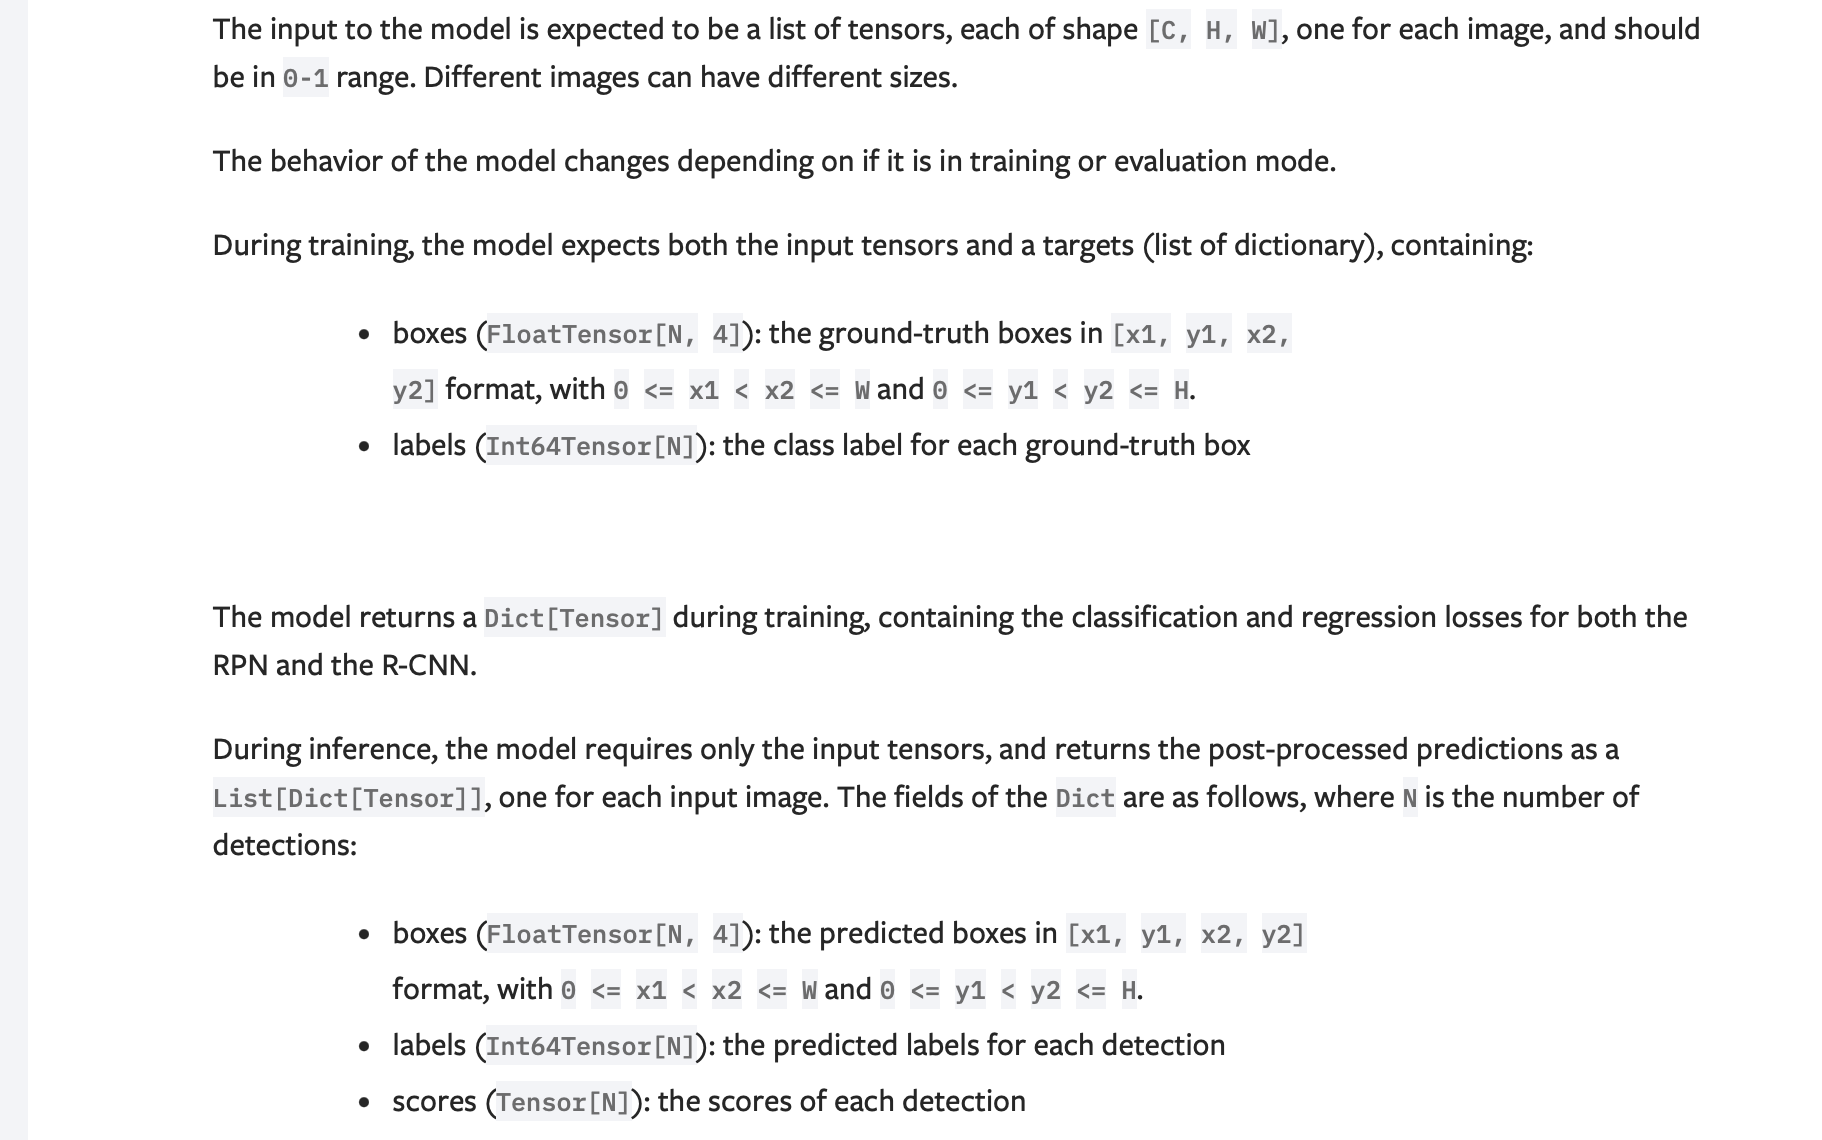


Ainsi, la perte associée est directement calculée par le modèle en entrainement. Cette perte est due à la fois à la région proposée (perte de régression), et à la classificiation de la région proposée (perte de classificiation) 

In [9]:
import torchvision 

from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights,fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torch import optim
import torch.nn as nn 
from  tqdm import tqdm as tqd

In [10]:
model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

model1.backbone.body.conv1 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True)



    
)
min_size = 640
max_size = 800  # very close to 798
image_mean = [0.485, 0.456]  # Only first 2 channels of original [0.485, 0.456, 0.406]
image_std = [0.229, 0.224]   # Only first 2 channels of original [0.229, 0.224, 0.225]
model1.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

num_classes = 5  # 4 classes + background
in_features = model1.roi_heads.box_predictor.cls_score.in_features
model1.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


print(model1)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456], std=[0.229, 0.224])
      Resize(min_size=(640,), max_size=800, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Sequential(
        (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (

Faisons un essai pour bien comprendre comment fonctionne ce modèle. 

In [12]:
a,b=next(iter(train_loader))
print(a[0].dtype,b[0]['boxes'].dtype,b[0]['labels'].dtype)
print(len(a),a[0].shape)
print(len(b))
model1.train()
res1=model1(a,b)
print("resultat 1 (train mode ) :", res1)

model1.eval()
res2=model1(a)
print("resultat 2 (éval mode ) :", res2)





torch.float32 torch.float32 torch.int64
4 torch.Size([2, 798, 640])
4


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


resultat 1 (train mode ) : {'loss_classifier': tensor(1.6441, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1474, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.8680, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0734, grad_fn=<DivBackward0>)}


KeyboardInterrupt: 

Comme on peut le voir : en mode évaluation, le modèle renvoie un dictionnaire contenant les différents coûts présentés précédemments.

In [11]:




def train(model, epochs,learning_rate, train_loader,test_loader) :
    optimizer=optim.Adam(model.parameters(),learning_rate)
    model.train()
    for ep in range(epochs) : 
        epoch_loss=0
        batch=0
        for x,target in train_loader : 
            optimizer.zero_grad()
            dict_loss=model(x,target)
            #loss_total=torch.tensor([dict_loss[i] for i in dict_loss.keys()],requires_grad=True).sum() Cette manière de créer la perte dans un nouveau tenseur ne permet apas de réaliser la retropropagation du gradient correctement
            loss_total = sum(loss for loss in dict_loss.values())
            loss_total.backward() 
            optimizer.step() 

            epoch_loss += loss_total.item()
            print("batch {}".format(batch))
            batch+=1
        print(f'Epoch {ep}: Loss = {epoch_loss/len(train_loader)}')
        torch.save(model.state_dict(), "model_weights.pth")

    files.download("model_weights.pth")

        
     




In [ ]:
train(model1,5,0.001,train_loader,6)

# Un peu de perfectionnement.



Nous avons un modèle de détection fonctionnel. Nous allons tenter de l'améliorer à travers plusieurs éléments : augmentation de données avec le framework Albumentations, une gestion optimisée de l'entrainement.


In [ ]:
!pip install albumentations


In [12]:
import albumentations as A



##Transform  classique 
transformer=transforms.Compose(
    [
        transforms.ToTensor()
    
    ]
)

##augmentation transform 

augmentation_transform=A.Compose(
    [
        # Géométriques
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        
        # Photométriques
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
     
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),

     


    ],
    bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels'] )
)


class dataset_LWAS_2_augmented(torch.utils.data.Dataset) : 

    def __init__(self, transform, augmentation, X, Y=None,preload=True,path=None,train=True) :
        if preload : 
            self.x=X
            self.y=Y
            self.transform=transform
            self.preload=True
            self.train=train
            self.augmentation=augmentation
        else : 
            self.augmentation=augmentation
            self.x=None
            self.y=None
            self.preload=False 
            self.transform=transform
            self.train=train
            if path is None : 
                raise     Exception("preload est fixé à False, mais aucun chemin n'est spécifié")
            self.path=path
            list_attempts_=os.listdir(path)
            self.list_x_names = list() 
            for i in  range(len(list_attempts_)) :
                if list_attempts_[i].split("_")[2]=="00.pkl" : 

                    list_attempts_[i]= list_attempts_[i].split("_")[0] +"_"+ list_attempts_[i].split("_")[1]
                    if list_attempts_[i] not in self.list_x_names :
                        self.list_x_names.append(list_attempts_[i])

            

    def __len__(self) : 
        if self.preload : 
            return len(self.x)
        else: 
            return len(self.list_x_names)
    
    def process_x_y(self,x,y=None) : 
                
                
                img=x['data']
                img=self.transform(img).to(device).to(torch.float32) ## Ici, je ne sais pasp ourquoi mais mes images s'ouvrent en float16 : obligé de forcer la conversion en float32
                #print("shape : ",img.shape)
                img=img.permute(1,2,0)
                img_width=img.shape[2]
                img_height=img.shape[1]
                
            
                if (self.preload and self.y is not None) or (not self.preload and self.train):
                    
                        boxes = []
                        labels = []
                        for box in y:
                            x_center, y_center, width, height = box['bbox']
                            
                    
                            x1 = (x_center - width/2) * img_width
                            y1 = (y_center - height/2) * img_height
                            x2 = (x_center + width/2) * img_width
                            y2 = (y_center + height/2) * img_height
                            
                        
                        
                            if x1 >= 0 and y1 >= 0 and x2 <= img_width and y2 <= img_height:
                                if x2 > x1 and y2 > y1:
                                    boxes.append([x1, y1, x2, y2])
                                    labels.append(box['class'] + 1)  

                        if boxes:
                            target = {
                                'boxes': torch.FloatTensor(boxes).to(device),
                                'labels': torch.tensor(labels, dtype=torch.int64).to(device)
                            }
                        else:
                            
                            target = {
                                'boxes': torch.FloatTensor(size=(0, 4)),
                                'labels': torch.tensor([], dtype=torch.int64)
                            }

                  
                        img=img.numpy()
               
                        img=np.transpose(img,(1,2,0))
                        transformed=self.augmentation(image=img,bboxes=target['boxes'].tolist(),class_labels=target["labels"].tolist())
                        target_augm=dict()
                        

                        boxes_tensor = torch.FloatTensor(transformed["bboxes"]).to(device)
                        labels_tensor = torch.tensor(transformed["class_labels"], dtype=torch.int64).to(device) 

                        print(type(boxes_tensor),type(labels_tensor))
                        
                        img,target_augm["boxes"],target_augm['labels']=transformed['image'],boxes_tensor,labels_tensor
                        img=self.transform(img).to(device).to(torch.float32)
                 
                        print(111)
                        if img.dim()==2 : 
                             img.unsqueeze_(0)
                        


                        return img, target_augm
                    
                return img
    
    def __getitem__(self,idx): 
       
        if self.preload: 
                    
                img=self.x[idx]
                if self.y is not None : 
                     y=self.y[idx]
                     img,target=self.process_x_y(x,y)
                     return img,target
                else : 
                    y=None
                    img=self.process_x_y(x,y)
                    return img
        else: 

            name_idx = self.list_x_names[idx]
            diag0_path = os.path.join(self.path ,(name_idx + "_00.pkl"))
            diag1_path = os.path.join(self.path, (name_idx + "_01.pkl"))
            diag0_lbl_path = os.path.join(self.path, (name_idx + "_00.txt"))
            diag1_lbl_path = os.path.join(self.path, (name_idx + "_01.txt"))
                                         

                # Load the diagnostic files
            with open(diag0_path, 'rb') as f:
                diag_0 = pickle.load(f)
            with open(diag1_path, 'rb') as f:
                diag_1 = pickle.load(f)

            diag_0_data = diag_0['data']
            diag_1_data = diag_1['data']
            combined_diag = {'data' : np.stack([diag_0_data, diag_1_data], axis=0)}
            print(111)
            if self.train :
                example_annotations = []
                for label_file in [diag0_lbl_path, diag1_lbl_path]:
                    if os.path.exists(label_file):
                        with open(label_file, 'r') as f:
                            for line in f:
                                parts = line.split()
                                class_id = int(parts[0])
                                x_center, y_center, width, height = map(
                                    float, parts[1:5])
                                example_annotations.append({
                                    'bbox': [x_center, y_center, width, height],
                                    'class': class_id
                                })
                img,target=self.process_x_y(combined_diag,example_annotations)
                return img, target
            else :
                  img=self.process_x_y(combined_diag,None) 
                  return img 


In [150]:
test_boxes = [[0.1, 0.1, 0.5, 0.5]]  # Normalisées
test_labels = [1]
test_image = np.ones((256, 256, 3), dtype=np.uint8)


t=augmentation_transform(image=test_image,bboxes=test_boxes,class_labels=test_labels)

In [ ]:
t["class_labels"]



In [13]:
from torch.utils.data import Subset,ConcatDataset,random_split

train_set_augmented=dataset_LWAS_2_augmented(transform=transformer,augmentation=augmentation_transform,X=None,Y=None,preload=False,path=path,train=True) 
train_set=dataset_LWAS_2(transform=transformer,X=None,Y=None,preload=False,path=path,train=True) 

train_size = int(0.8 * len(train_set))  # 80% pour l'entraînement
eval_size = len(train_set) - train_size  # 20% pour la validation


train_set, eval_set = random_split(train_set, [train_size, eval_size])
train_set_augmented=Subset(train_set_augmented,range(0,500,2))

combined_dataset=ConcatDataset([train_set_augmented,train_set]) 


In [14]:
###Pour vérifs 

print(train_set.__len__())
print(eval_set.__len__())
print(train_set_augmented.__len__())
print(combined_dataset.__len__())


803
201
250
1053


In [19]:
combined_loader=DataLoader(combined_dataset,batch_size=20,shuffle=True,collate_fn=lambda x: tuple(zip(*x)))
train_loader=DataLoader(train_set,batch_size=20,shuffle=True,collate_fn=lambda x: tuple(zip(*x)))

eval_loader=DataLoader(eval_set,batch_size=20,shuffle=True,collate_fn=lambda x: tuple(zip(*x)))


In [20]:
next(iter(combined_loader))
next(iter(eval_loader))
next(iter(train_loader))




111
<class 'torch.Tensor'> <class 'torch.Tensor'>
111
111
<class 'torch.Tensor'> <class 'torch.Tensor'>
111
111
<class 'torch.Tensor'> <class 'torch.Tensor'>
111
111
<class 'torch.Tensor'> <class 'torch.Tensor'>
111


((tensor([[[0.5830, 1.0078, 1.0654,  ..., 1.0664, 1.0000, 0.0000],
           [0.5840, 1.0078, 1.0654,  ..., 1.0664, 1.0000, 0.0000],
           [0.5845, 1.0078, 1.0654,  ..., 1.0664, 1.0000, 0.0000],
           ...,
           [0.5845, 1.0078, 1.0654,  ..., 1.0664, 1.0000, 0.0000],
           [0.5840, 1.0078, 1.0654,  ..., 1.0664, 1.0000, 0.0000],
           [0.5830, 1.0078, 1.0654,  ..., 1.0664, 1.0000, 0.0000]],
  
          [[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
           ...,
           [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
           [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]]]),
  tensor([[[0.6455, 1.0762, 1.1338,  ..., 1.0664, 1.0000, 0.0000],
           [0.6479, 1.0762, 1.1328,  ..., 1.0664, 1.00

In [28]:
b


({'boxes': tensor([[243.6125, 307.3242, 434.3741, 480.2588],
          [436.8515, 306.2824, 618.5290, 477.1334],
          [356.7488, 382.3322, 639.1744, 413.5851],
          [362.0403, 366.8458, 417.2941, 429.1273]]),
  'labels': tensor([2, 2, 3, 1])},
 {'boxes': tensor([[355.0967, 288.0509, 639.1741, 513.0741],
          [356.7488, 356.2870, 485.5744, 439.1083],
          [526.8646, 334.9310, 624.3098, 461.5065]]),
  'labels': tensor([3, 1, 1])})

111
<class 'torch.Tensor'> <class 'torch.Tensor'>
111
111
<class 'torch.Tensor'> <class 'torch.Tensor'>
111


KeyboardInterrupt: 

In [44]:
!pip install pandas

In [21]:
import pandas as pd 
path_folder="./results.xlsx"
def train_2(model, epochs,learning_rate, train_loader,test_loader,path_xls,identifiant="non augmenté") :
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for ep in range(epochs):

        epoch_loss = 0
        batch = 0
        for x, target in train_loader:
            optimizer.zero_grad()
            dict_loss = model(x, target)
            loss_total = sum(loss for loss in dict_loss.values())
            loss_total.backward()
            optimizer.step()

            epoch_loss += loss_total.item()
            
            batch += 1

        avg_train_loss = epoch_loss / len(train_loader)
       
        print(f"Epoch {ep}: Evaluation Loss = {avg_train_loss:.4f}")
    
    
        model.eval()  
        eval_loss = 0
        with torch.no_grad(): 
            for x, target in test_loader:
                dict_loss = model(x, target)
                loss_total = sum(loss for loss in dict_loss.values())
                eval_loss += loss_total.item()

        avg_eval_loss = eval_loss / len(test_loader)
        print(f"Epoch {ep}: Evaluation Loss = {avg_eval_loss:.4f}")

        df=pd.read_excel(path_xls)
        df=pd.concat([df,pd.DataFrame({"identifiant" : [identifiant], "epoch" : [ep], "train_loss" : [avg_train_loss], "eval_loss" : [avg_eval_loss]})])
        df.to_excel(path_xls)


        model.train()  



        # Sauvegarder les poids après chaque époque
        torch.save(model.state_dict(), "model_weights.pth")

    print("Training complete.")
    #files.download("model_weights-{}.pth".format())


In [24]:

df=pd.DataFrame({"identifiant" : [], "epoch" : [], "train_loss" : [], "eval_loss" : []})
df.to_excel(path_folder)



In [23]:
!pip install openpyxl

In [26]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

model2.backbone.body.conv1 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True)



    
)
min_size = 640
max_size = 800  # very close to 798
image_mean = [0.485, 0.456]  # Only first 2 channels of original [0.485, 0.456, 0.406]
image_std = [0.229, 0.224]   # Only first 2 channels of original [0.229, 0.224, 0.225]
model2.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

num_classes = 5  # 4 classes + background
in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)




In [27]:
#from google.colab import files
train_2(model2,10,0.001,train_loader,eval_loader,path_folder,"non augmenté")

model3 = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

model3.backbone.body.conv1 = nn.Sequential(
    nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True)



    
)
min_size = 640
max_size = 800  # very close to 798
image_mean = [0.485, 0.456]  # Only first 2 channels of original [0.485, 0.456, 0.406]
image_std = [0.229, 0.224]   # Only first 2 channels of original [0.229, 0.224, 0.225]
model3.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

num_classes = 5  # 4 classes + background
in_features = model3.roi_heads.box_predictor.cls_score.in_features
model3.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

train_2(model3,10,0.001,combined_loader,eval_loader,path_folder,"augmenté")

files.download(path_folder)

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


KeyboardInterrupt: 